In [2]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso 
import warnings
from sklearn.utils import resample
from numba import jit

/var/folders/2g/lgqxddy17rb530lgfvfz7dl40000gn/T/ipykernel_14399/1710940366.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('../reference_material/oslo.tif')


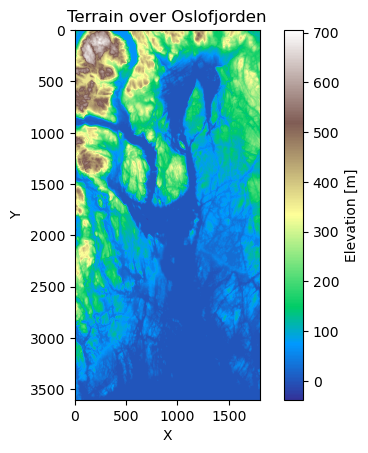

In [3]:
COLORMAP = "terrain"  # color map for countour plots

# Load the terrain
terrain = imread('../reference_material/oslo.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Oslofjorden')
plt.imshow(terrain, cmap=COLORMAP)
plt.colorbar(label="Elevation [m]")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Implementing task a) to terrain data

In [20]:

def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)


def R2_score(y_actual, y_model):
    """Returns the R2 score of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return 1 - np.sum((y_actual - y_model)**2) / np.sum((y_actual - np.mean(y_actual))**2)




# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()


# PARAMETERS
N = 500  # number of data points
maxdegree = 20  # max polynomial degree for plotting

# Creates mesh of image pixels
z = terrain[:N, :N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()


# Initialize scaler
scaler = StandardScaler()

degrees = np.arange(0, maxdegree, 1)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)
train_r2 = np.empty_like(train_mse)
test_r2 = np.empty_like(train_mse)
beta_arr = []

# Iterate through all the different polynomial degrees
for degree in degrees:
    
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector
    # the flattened x and y arrays are stacked side by side to be passed into 
    # PolynomialFeatures.fit_transform to create our design matrix
    features = np.column_stack((x_flat, y_flat))
    X = polynomial_model.fit_transform(features)

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)

    # Scale design matrix data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale z data  
    z_train = z_train.reshape((z_train.size, 1))
    z_test = z_test.reshape((z_test.size, 1))
    
    scaler.fit(z_train)
    z_train_scaled = scaler.transform(z_train)
    z_test_scaled = scaler.transform(z_test)

    # Ordinary least squares linear regression
    beta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train_scaled
    z_tilde = X_train_scaled @ beta
    z_predict = X_test_scaled @ beta

    # Store beta value for plotting
    beta_arr.append(beta)
    
    
    # Store the MSE and R2 values
    train_mse[degree] = MSE(z_train_scaled, z_tilde)
    test_mse[degree] = MSE(z_test_scaled, z_predict)
    train_r2[degree] = R2_score(z_train_scaled, z_tilde)
    test_r2[degree] = R2_score(z_test_scaled, z_predict)

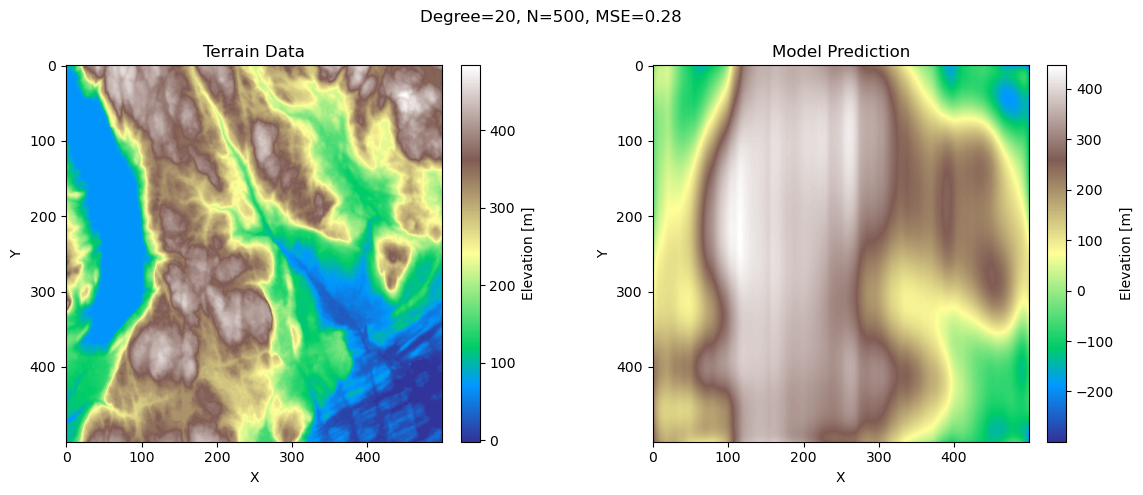

In [114]:
# PARAMETERS
N = 500  # number of data points
maxdegree = 20  # max polynomial degree for plotting

# Creates mesh of image pixels
z = terrain[0:N, N:2*N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

# Create a mesh grid for visualization of our model 
x_pred = np.linspace(0, 1, np.shape(z)[0])
y_pred = np.linspace(0, 1, np.shape(z)[1])
x_pred, y_pred = np.meshgrid(x_pred, y_pred)

# Flatten and scale the mesh grid for our prediction model
x_pred_flat = x_pred.flatten()
y_pred_flat = y_pred.flatten()
features_pred = np.column_stack((x_pred_flat, y_pred_flat))
X_pred = polynomial_model.transform(features_pred)

# Scale design matrix data
scaler.fit(X_pred)
X_pred_scaled = scaler.transform(X_pred)

# Applying our calculated beta to the meshgrid.
z_pred = X_pred_scaled @ beta

# Reshape the predictions to match the shape of the original terrain data
z_pred = z_pred.reshape(z.shape)


# Set a common colormap for both plots
COLORMAP = "terrain"  # color map for countour plots


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# Keyword arguments to fit colorbar height to the plots
frac = 0.046
pad = 0.04

# Plot the original terrain data on the left subplot
axs[0].set_title('Terrain Data')
im1 = axs[0].imshow(z, cmap=COLORMAP, origin='upper')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im1, ax=axs[0], label="Elevation [m]", fraction=frac, pad=pad)

# Plot the predicted terrain on the right subplot
axs[1].set_title('Model Prediction')

scaler.fit(z_pred)
z_scaled = scaler.inverse_transform(z_pred)

# MSE between real terrain data and our model
MSE_model_fit = MSE(z_scaled.flatten(), z_pred.flatten())

im2 = axs[1].imshow(z_pred_inv, cmap=COLORMAP, origin='upper')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im2, ax=axs[1], label="Elevation [m]", fraction=frac, pad=pad)
fig.suptitle(f"Degree={maxdegree}, {N=}, MSE={np.round(MSE_model_fit,2)}")
# Adjust spacing between subplots
plt.tight_layout()
#plt.savefig(FIGURES_DIR / "part_g_task_a.png")
# Show the figure with both subplots
plt.show()

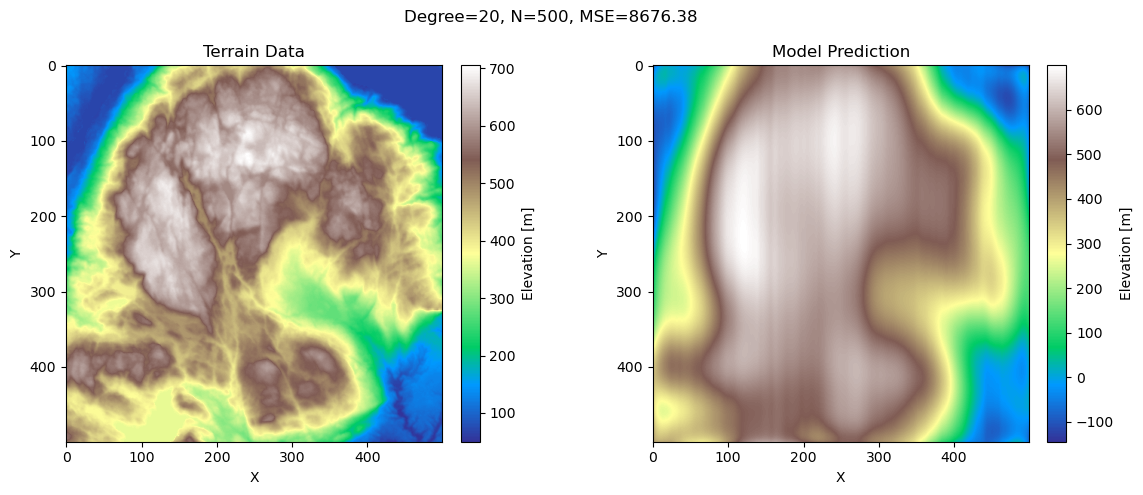

In [101]:
# Create a mesh grid for visualization of our model 
x_pred = np.linspace(0, 1, np.shape(z)[0])
y_pred = np.linspace(0, 1, np.shape(z)[1])
x_pred, y_pred = np.meshgrid(x_pred, y_pred)

# Flatten and scale the mesh grid for our prediction model
x_pred_flat = x_pred.flatten()
y_pred_flat = y_pred.flatten()
features_pred = np.column_stack((x_pred_flat, y_pred_flat))
X_pred = polynomial_model.transform(features_pred)

# Scale design matrix data
scaler.fit(X_pred)
X_pred_scaled = scaler.transform(X_pred)

# Applying our calculated beta to the meshgrid.
z_pred = X_pred_scaled @ beta

# Reshape the predictions to match the shape of the original terrain data
z_pred = z_pred.reshape(z.shape)


# Set a common colormap for both plots
COLORMAP = "terrain"  # color map for countour plots


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# Keyword arguments to fit colorbar height to the plots
frac = 0.046
pad = 0.04

# Plot the original terrain data on the left subplot
axs[0].set_title('Terrain Data')
im1 = axs[0].imshow(z, cmap=COLORMAP, origin='upper')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im1, ax=axs[0], label="Elevation [m]", fraction=frac, pad=pad)

# Plot the predicted terrain on the right subplot
axs[1].set_title('Model Prediction')

scaler.fit(z)
z_pred_inv = scaler.inverse_transform(z_pred)

# MSE between real terrain data and our model
MSE_model_fit = MSE(z.flatten(), z_pred_inv.flatten())

im2 = axs[1].imshow(z_pred_inv, cmap=COLORMAP, origin='upper')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im2, ax=axs[1], label="Elevation [m]", fraction=frac, pad=pad)
fig.suptitle(f"Degree={maxdegree}, {N=}, MSE={np.round(MSE_model_fit,2)}")
# Adjust spacing between subplots
plt.tight_layout()
#plt.savefig(FIGURES_DIR / "part_g_task_a.png")
# Show the figure with both subplots
plt.show()

In [53]:
z.shape

(500, 500)

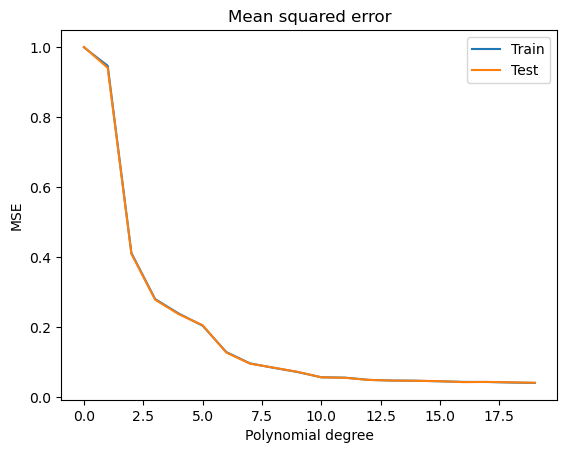

In [21]:
# Plot the MSE as function of poly. degree
plt.figure()
plt.plot(degrees, train_mse, label="Train")

plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.title("Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.savefig(FIGURES_DIR / "part_g_task_a_MSE.png")

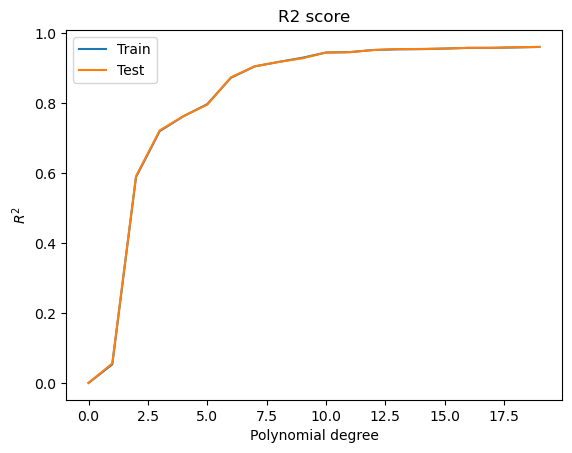

In [116]:
# Plot R2 scores as function of poly. degree 
plt.figure()
plt.plot(degrees, train_r2, label="Train")
plt.plot(degrees, test_r2, label="Test")
plt.legend()
plt.title("R2 score")
plt.xlabel("Polynomial degree")
plt.ylabel("$R^2$")
plt.savefig(FIGURES_DIR / "part_g_task_a_R2.png")

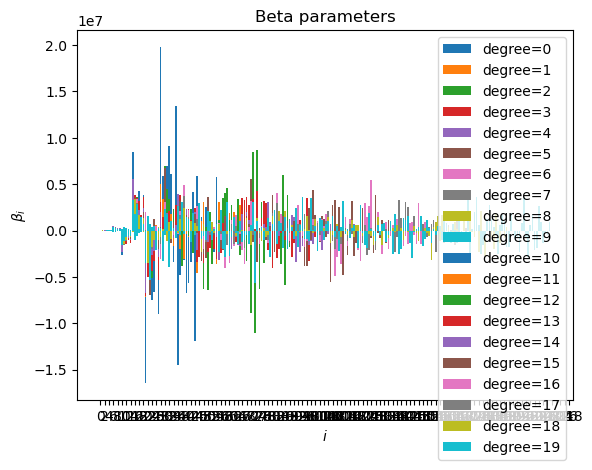

In [20]:
# Now plot the beta parameters 
plt.figure()
for degree in degrees:
    plt.bar(
            range(beta_arr[degree].size),  # indices
            beta_arr[degree],
            label=f"{degree=}",
    )
plt.legend()
plt.xticks(np.arange(plt.xlim()[1], step=2))
plt.title("Beta parameters")
plt.xlabel("$i$")
plt.ylabel(r"$\beta_i$")
plt.savefig(FIGURES_DIR / "part_g_task_a_Beta.png")

# Implementing task b) to terrain data

In [22]:
def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)


def R2_score(y_actual, y_model):
    """Returns the R2 score of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return 1 - np.sum((y_actual - y_model)**2) / np.sum((y_actual - np.mean(y_actual))**2)


def MSE_Ridge_beta_R2(X_train, X_test, y_train, y_test, lamb):
    """Performs Ridge regression and returns the MSE, R2, and beta values for each lambda value in lamb."""
    mse_test = np.zeros(len(lamb))
    mse_train = np.zeros(len(lamb))
    r2_train = np.zeros(len(lamb))
    r2_test = np.zeros(len(lamb))
    beta = []

    I = np.identity(X_train.shape[1])
    for i in range(len(lamb)):
        # Make ridge regression
        beta_rid = np.linalg.pinv(X_train.T @ X_train + lamb[i] * I) @ X_train.T @ y_train

        # Make prediction
        y_tilde = X_train @ beta_rid
        y_predict = X_test @ beta_rid

        # Compute MSE, beta and R2 values
        mse_train[i] = MSE(y_train, y_tilde)
        mse_test[i] = MSE(y_test, y_predict)
        beta.append(beta_rid)
        r2_train[i] = R2_score(y_train, y_tilde)
        r2_test[i] = R2_score(y_test, y_predict)
    return mse_train, mse_test, beta, r2_train, r2_test



"""
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""


# PARAMETERS
N = 500  # number of data points
maxdegree = 20  # max polynomial degree for plotting
lmbda_vals = np.linspace(0.0001, 1, 50)
noise_std = 1

# Creates mesh of image pixels
z = terrain[:N, :N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

scaler = StandardScaler()

# Make lists which will contain plot data
degrees = np.arange(0, maxdegree, 1)
mse_train_arr = []
mse_test_arr = []
beta_arr = []
r2_train_arr = []
r2_test_arr = []

# Iterate through all the different polynomial degrees
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector
    # the flattened x and y arrays are stacked side by side to be passed into 
    # PolynomialFeatures.fit_transform to create our design matrix
    features = np.column_stack((x_flat, y_flat))
    X = polynomial_model.fit_transform(features)

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)

    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform ridge regression
    mse_train, mse_test, beta, r2_train, r2_test = MSE_Ridge_beta_R2(
            X_train_scaled, X_test_scaled, z_train, z_test, lmbda_vals)
    mse_train_arr.append(mse_train)
    mse_test_arr.append(mse_test)
    beta_arr.append(beta)
    r2_train_arr.append(r2_train)
    r2_test_arr.append(r2_test)

In [23]:
# Plot MSE's
figsize = (8, 5)
fig = plt.figure()
fig.suptitle("MSE values")
for degree in degrees:
    plt.subplot(3, 2, degree)
    plt.title(f"{degree=}")
    plt.plot(lmbda_vals, mse_train_arr[degree], label=f"Train")
    plt.plot(lmbda_vals, mse_test_arr[degree], label=f"Test")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
plt.tight_layout()

ValueError: num must be an integer with 1 <= num <= 6, not 0

<Figure size 640x480 with 0 Axes>

ValueError: num must be an integer with 1 <= num <= 6, not 7

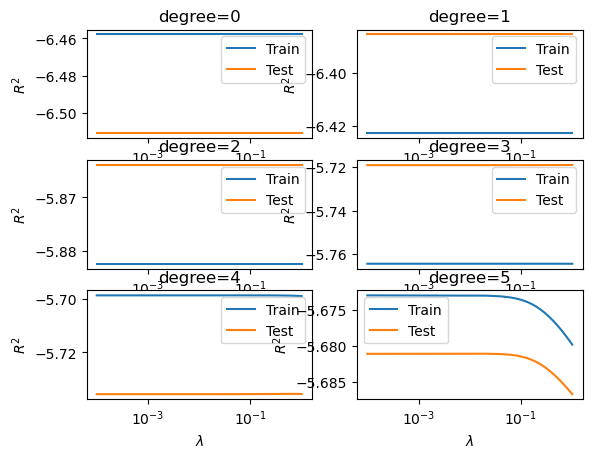

In [24]:
# Plot R2's
# fig = plt.figure(figsize=figsize)
fig.suptitle("R2 scores")
for degree in degrees:
    plt.subplot(3, 2, degree + 1)
    plt.title(f"{degree=}")
    plt.plot(lmbda_vals, r2_train_arr[degree], label=f"Train")
    plt.plot(lmbda_vals, r2_test_arr[degree], label=f"Test")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("$R^2$")
    plt.xscale("log")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "part_g_task_b_R2.png")

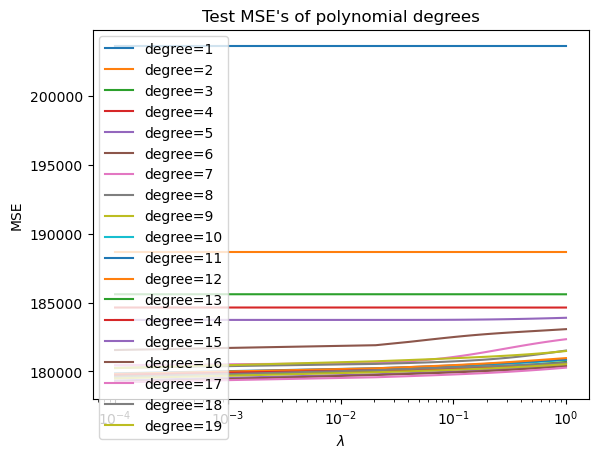

In [25]:
# Plot test MSE's in same figure
# plt.figure(figsize=figsize)
plt.title("Test MSE's of polynomial degrees")
for degree in degrees[1:]:
    plt.plot(lmbda_vals, mse_test_arr[degree], label=f"{degree=}")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
plt.savefig(FIGURES_DIR / "part_g_task_b_MSE.png")

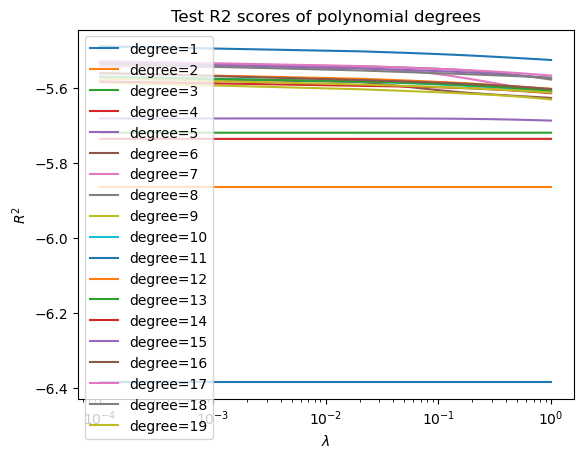

In [26]:
# Plot test R2's in same figure
# plt.figure(figsize=figsize)
plt.title("Test R2 scores of polynomial degrees")
for degree in degrees[1:]:
    plt.plot(lmbda_vals, r2_test_arr[degree], label=f"{degree=}")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("$R^2$")
    plt.xscale("log")
plt.savefig(FIGURES_DIR / "part_g_task_b_R2_lambda.png")

In [20]:
# Print lambda with lowest MSE for each degree
print("OPTIMAL λ-VALS FOR EACH POLY. DEGREE:")
for degree in degrees:
    print(f"{degree=}: λ={lmbda_vals[np.argmin(mse_test_arr[degree])]}")

OPTIMAL λ-VALS FOR EACH POLY. DEGREE:
degree=0: λ=0.0001
degree=1: λ=0.0001
degree=2: λ=1.0
degree=3: λ=1.0
degree=4: λ=0.06131836734693878
degree=5: λ=0.04091224489795919
degree=6: λ=0.0001
degree=7: λ=0.0001
degree=8: λ=0.0001
degree=9: λ=0.0001
degree=10: λ=0.0001
degree=11: λ=0.0001
degree=12: λ=0.0001
degree=13: λ=0.0001
degree=14: λ=0.0001
degree=15: λ=0.0001
degree=16: λ=0.0001
degree=17: λ=0.0001
degree=18: λ=0.0001
degree=19: λ=0.0001


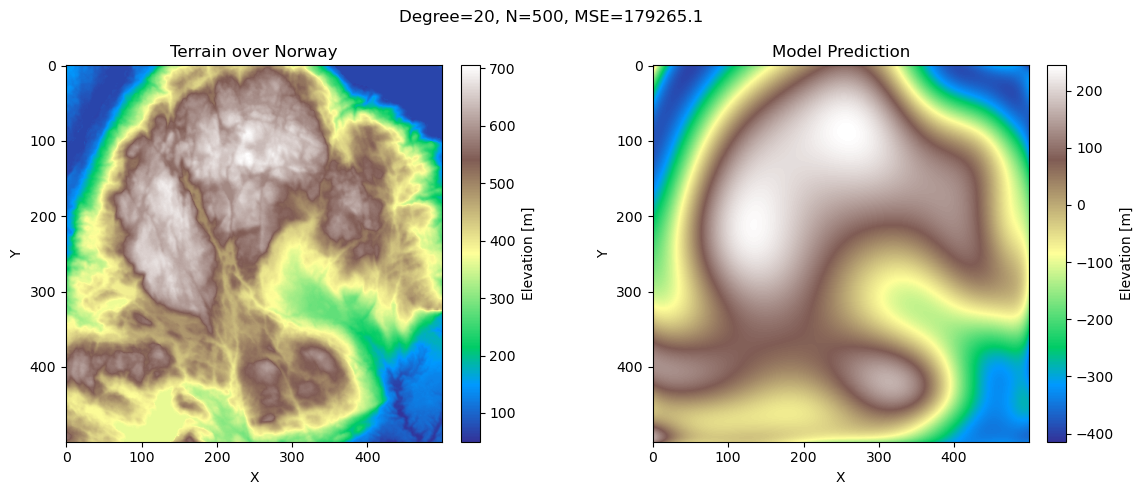

In [29]:
min_beta = beta_arr[-1][0] # beta corresponding to lowest MSE, which is lambda 0.0001
min_lmda = 0.0001 # lambda corresponding to lowest MSE
min_degree = 19 # degree corresponding to lowest MSE


# Create a mesh grid for visualization of our model 
z = terrain[:N, :N]
x_pred = np.linspace(0, 1, np.shape(z)[0])
y_pred = np.linspace(0, 1, np.shape(z)[1])
x_pred, y_pred = np.meshgrid(x_pred, y_pred)

# Flatten and scale the mesh grid for our prediction model
x_pred_flat = x_pred.flatten()
y_pred_flat = y_pred.flatten()
features_pred = np.column_stack((x_pred_flat, y_pred_flat))
X_pred = polynomial_model.transform(features_pred)
X_pred_scaled = scaler.transform(X_pred)

# Applying our calculated beta to the meshgrid.
z_pred = X_pred_scaled @ min_beta

# Reshape the predictions to match the shape of the original terrain data
z_pred = z_pred.reshape(z.shape)


# Set a common colormap for both plots
COLORMAP = "terrain"  # color map for countour plots

# MSE between real terrain data and our model
MSE_model_fit = MSE(z.flatten(), z_pred.flatten())

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Degree={maxdegree}, {N=}, MSE={round(MSE_model_fit,2)}")

# Keyword arguments to fit colorbar height to the plots
frac = 0.046
pad = 0.04

# Plot the original terrain data on the left subplot
axs[0].set_title('Terrain over Norway')
im1 = axs[0].imshow(z, cmap=COLORMAP, origin='upper')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im1, ax=axs[0], label="Elevation [m]", fraction=frac, pad=pad)

# Plot the predicted terrain on the right subplot
axs[1].set_title('Model Prediction')
im2 = axs[1].imshow(z_pred, cmap=COLORMAP, origin='upper')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im2, ax=axs[1], label="Elevation [m]", fraction=frac, pad=pad)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(FIGURES_DIR / "part_g_task_b_model.png")
# Show the figure with both subplots
plt.show()

# Implementing task c) to terrain data

In [30]:
warnings.filterwarnings('ignore')

In [31]:
def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)


def R2_score(y_actual, y_model):
    """Returns the R2 score of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return 1 - np.sum((y_actual - y_model)**2) / np.sum((y_actual - np.mean(y_actual))**2)


"""
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""

# PARAMETERS
N = 500  # number of data points
maxdegree = 20  # max polynomial degree for plotting
lmbda_vals = np.linspace(0.0001, 1, 50)
noise_std = 1

# Creates mesh of image pixels
z = terrain[:N, :N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()


# Initialize scaler and lasso regression
scaler = StandardScaler()
lasso = Lasso(fit_intercept=False)  # include intercept

degrees = np.arange(0, maxdegree, 1)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)
train_r2 = np.empty_like(train_mse)
test_r2 = np.empty_like(train_mse)
beta_arr = []

# Iterate through all the different polynomial degrees
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector
    # the flattened x and y arrays are stacked side by side to be passed into 
    # PolynomialFeatures.fit_transform to create our design matrix
    features = np.column_stack((x_flat, y_flat))
    X = polynomial_model.fit_transform(features)

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)

    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Lasso regression
    lasso.fit(X_train_scaled, z_train)
    z_tilde = lasso.predict(X_train_scaled)
    z_predict = lasso.predict(X_test_scaled)

    # Store the MSE and R2 values
    train_mse[degree] = MSE(z_train, z_tilde)
    test_mse[degree] = MSE(z_test, z_predict)
    train_r2[degree] = R2_score(z_train, z_tilde)
    test_r2[degree] = R2_score(z_test, z_predict)

Text(0, 0.5, 'MSE')

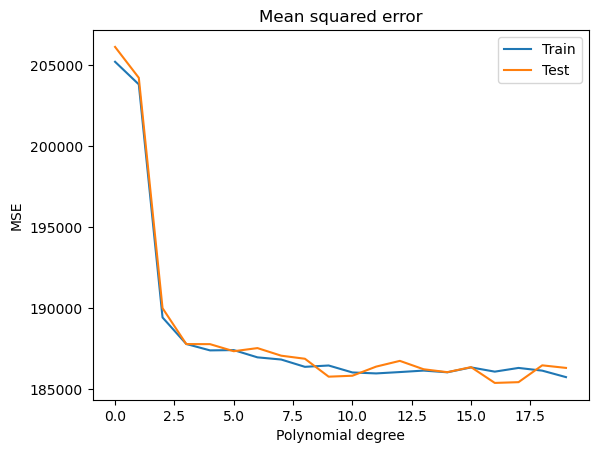

In [90]:
# Plot the MSE as function of poly. degree
plt.plot(degrees, train_mse, label="Train")
plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.title("Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.savefig(FIGURES_DIR / "part_g_task_c_MSE.png")

Text(0, 0.5, '$R^2$')

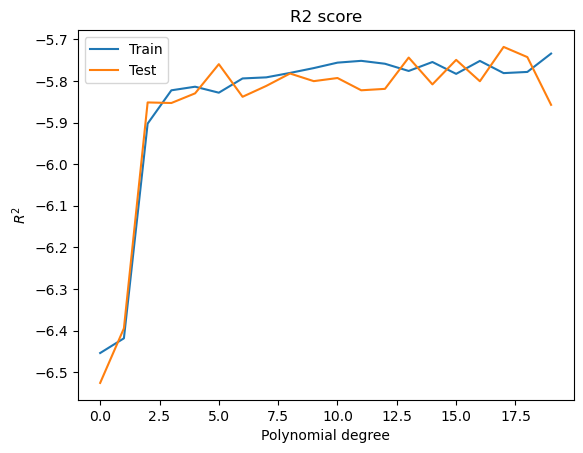

In [91]:
# Plot R2 scores as function of poly. degree 
plt.plot(degrees, train_r2, label="Train")
plt.plot(degrees, test_r2, label="Test")
plt.legend()
plt.title("R2 score")
plt.xlabel("Polynomial degree")
plt.ylabel("$R^2$")
plt.savefig(FIGURES_DIR / "part_g_task_c_R2.png")

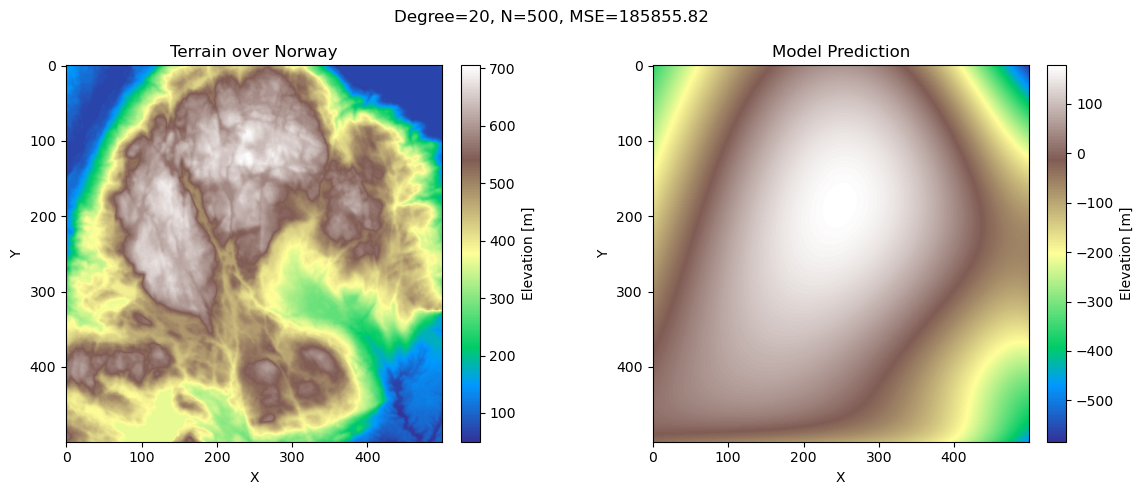

In [93]:
# Create a mesh grid for visualization of our model 
z = terrain[:N, :N]
x_pred = np.linspace(0, 1, np.shape(z)[0])
y_pred = np.linspace(0, 1, np.shape(z)[1])
x_pred, y_pred = np.meshgrid(x_pred, y_pred)

# beta from lasso regression
beta = lasso.coef_

# Flatten and scale the mesh grid for our prediction model
x_pred_flat = x_pred.flatten()
y_pred_flat = y_pred.flatten()
features_pred = np.column_stack((x_pred_flat, y_pred_flat))
X_pred = polynomial_model.transform(features_pred)
X_pred_scaled = scaler.transform(X_pred)

# Applying our calculated beta to the meshgrid.
z_pred = X_pred_scaled @ beta

# Reshape the predictions to match the shape of the original terrain data
z_pred = z_pred.reshape(z.shape)


# Set a common colormap for both plots
COLORMAP = "terrain"  # color map for countour plots

# MSE between real terrain data and our model
MSE_model_fit = MSE(z.flatten(), z_pred.flatten())

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Degree={maxdegree}, {N=}, MSE={np.round(MSE_model_fit,2)}")

# Keyword arguments to fit colorbar height to the plots
frac = 0.046
pad = 0.04


# Plot the original terrain data on the left subplot
axs[0].set_title('Terrain over Norway')
im1 = axs[0].imshow(z, cmap=COLORMAP, origin='upper')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im1, ax=axs[0], label="Elevation [m]", fraction=frac, pad=pad)

# Plot the predicted terrain on the right subplot
axs[1].set_title('Model Prediction')
im2 = axs[1].imshow(z_pred, cmap=COLORMAP, origin='upper')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_aspect('equal')  # Set aspect ratio to equal
fig.colorbar(im2, ax=axs[1], label="Elevation [m]", fraction=frac, pad=pad)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(FIGURES_DIR / "part_g_task_c_model.png")
# Show the figure with both subplots
plt.show()

# Implementing task e) to terrain data

In [7]:
def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)

def MSE_bootstrap(y_actual, y_model):
    """Returns the mean squared error of the two arrays with bootstrap."""
    return np.mean(np.mean((y_actual - y_model)**2, axis=1, keepdims=True))

def bias_bootstrap(y_actual, y_model):
    """Returns the bias of the two arrays with bootstrap."""
    return np.mean((y_actual - np.mean(y_model, axis=1, keepdims=True))**2)


def variance_bootstrap(y):
    """Returns the variance of the array with bootstrap"""
    return np.mean(np.var(y, axis=1, keepdims=True))

"""
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""

'\n# Figure output directory\nRESULTS_DIR = Path("../results").resolve()\nFIGURES_DIR = RESULTS_DIR / "figures"\n\n# Create them if they dont exist\nif not RESULTS_DIR.exists():\n    RESULTS_DIR.mkdir()\n\nif not FIGURES_DIR.exists():\n    FIGURES_DIR.mkdir()\n'

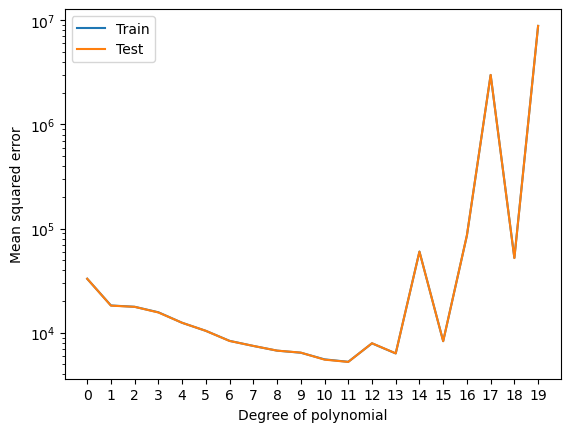

In [120]:
# PARAMETERS
N = 1000  # number of data points
maxdegree = 20  # max polynomial degree for plotting

# Creates mesh of image pixels
z = terrain[:N, :N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

#degrees = np.arange(maxdegree)
degrees = np.arange(0, maxdegree, 1)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)


# Then loop over the degrees again to do the mean error calculations
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector
    # the flattened x and y arrays are stacked side by side to be passed into 
    # PolynomialFeatures.fit_transform to create our design matrix
    features = np.column_stack((x_flat, y_flat))
    X = polynomial_model.fit_transform(features)

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.3)

    # OLS regression
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta
    z_predict = X_test @ beta
    
    # Store MSE vals
    train_mse[degree] = MSE(z_train, z_tilde)
    test_mse[degree] = MSE(z_test, z_predict)

# Plotting
plt.plot(degrees, train_mse, label="Train");
plt.plot(degrees, test_mse, label="Test");
plt.legend();
plt.xlabel("Degree of polynomial");
plt.ylabel("Mean squared error");  
plt.yscale("log");
plt.xticks(degrees);
#plt.savefig(FIGURES_DIR / "part_e_bias_variance_hastie.png")

In [122]:
# GLOBAL PARAMETERS
n_bootstraps = 100  # no. bootstrap resamples

In [ ]:
######### BIAS-VARIANCE AS FUNCTION OF POLY. DEGREE #############


# PARAMETERS
N = 500  # number of data points
maxdegree = 2  # max polynomial degree for plotting

# Creates mesh of image pixels
z = terrain[:N, :N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

# Initialize scaler
scaler = StandardScaler()

# Init arrays
degrees = np.arange(0, maxdegree, 1)
mse_arr = np.empty(degrees.shape)
bias_arr = np.empty_like(mse_arr)
var_arr = np.empty_like(mse_arr)

# Iterate through all the different polynomial degrees
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector
    # the flattened x and y arrays are stacked side by side to be passed into 
    # PolynomialFeatures.fit_transform to create our design matrix
    features = np.column_stack((x_flat, y_flat))
    X = polynomial_model.fit_transform(features)

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    
    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Bootstrap resampling
    z_predict = np.empty((z_test.shape[0], n_bootstraps))
    for i in range(n_bootstraps):
        X_, z_ = resample(X_train_scaled, z_train)
        
        # OLS regression
        beta = np.linalg.pinv(X_.T @ X_) @ X_.T @ z_
        z_predict[:, i] = X_test_scaled @ beta
        
    # Store the MSE, bias, and variance
    #mse_arr[degree] = MSE_bootstrap(z_test, z_predict)
    bias_arr[degree] = bias_bootstrap(z_test, z_predict)
    var_arr[degree] = variance_bootstrap(z_predict)
    
plt.plot(degrees, mse_arr, label='Test MSE')
plt.plot(degrees, bias_arr, label='bias')
plt.plot(degrees, var_arr, label='Variance')
plt.xlabel("Polynomial degree")
plt.ylabel("Metric")
plt.title(f"{N=}, {n_bootstraps=}")
plt.xticks(range(0, degree_max, 2))
plt.legend()
#plt.savefig(FIGURES_DIR / "part_e_mse_polydeg.png")

# Print best poly degree
best_poly_deg = np.argmin(mse_arr)
print(f"Polynomial degree with minimum MSE = {best_poly_deg}")

# Implementing task f) to terrain data

In [5]:
def MSE(y, y_tilde):
    """Returns the mean squared error of the two arrays."""
    return np.mean((y - y_tilde)**2)


def R2_score(y, y_tilde):
    """Returns the R2 score of the two arrays."""
    return 1 - np.sum((y - y_tilde)**2) / np.sum((y - np.mean(y))**2)


""" Below is a function for each method OLS, Ridge and Lasso. 

    Args
    
    OLS_model(maxdegree, input_folds):
        Takes in maximum degree of polynomials (int) and number of folds (int)

    Ridge_model(maxdegree, lamb, input_folds):
        Takes in maximum degree of polynomials (int), lambda value (float) and number of folds (int)

    Lasse_model(maxdergee, input_folds):
        Takes in maximum degree of polynomials (int) and number of folds (int)
    
    
    Return 

    Each function returns the methods MSE value.

"""

# PARAMETERS
N = 500  # number of data points
maxdegree = 2  # max polynomial degree for plotting

# Creates mesh of image pixels
z = terrain[:N, :N]
x = np.linspace(0, 1, np.shape(z)[0])
y = np.linspace(0, 1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()




def OLS_model(maxdegree, input_folds):
    scaler = StandardScaler()
    
    degrees = np.arange(0, maxdegree, 1)
    train_mse = np.empty(degrees.shape)
    test_mse = np.empty_like(train_mse)
    train_r2 = np.empty_like(train_mse)
    test_r2 = np.empty_like(train_mse)
    beta_arr = []
    
    # Iterate through all the different polynomial degrees
    for degree in degrees:
        
        # Create design matrix X
        # tell the model what degree of polynomial we want
        polynomial_model = PolynomialFeatures(degree)
    
        # use the package to create a design matrix for a second degree polynomial
        # by converting x to a column vector
        # the flattened x and y arrays are stacked side by side to be passed into 
        # PolynomialFeatures.fit_transform to create our design matrix
        features = np.column_stack((x_flat, y_flat))
        X = polynomial_model.fit_transform(features)
    
        degrees_fold = np.arange(0, maxdegree, 1)
        train_mse_fold = np.empty(degrees.shape)
        test_mse_fold = np.empty_like(train_mse)
        train_r2_fold = np.empty_like(train_mse)
        test_r2_fold = np.empty_like(train_mse)
    
        
        """ Implementing cross validation for n_folds. Using the KFold from 
            sklearn.model_selection to split the data into two pieces
            train and test, given the input value n_splits which determines how many folds 
            with train and test pairs are created. 
        
            The loops uses two iterators train and test to loop through KFold and extracts 
            the indexes for the train and test arrays. Thus the iterators are essentially 
            extracting the elements indexes of the matrix. Furthermore, the MSE and R2 scores
            are calculated for each fold and then they are taken the mean of before plotted.
            
            Inspired from (codebasics, 2019)
        """
    
        n_folds = input_folds
        kf = KFold(n_splits=n_folds)
        for train, test in kf.split(X):
            X_train, X_test, z_train, z_test = X[train], X[test], z_flat[train], z_flat[test]
            
            # Scale data
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            # Ordinary least squares linear regression
            beta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train
            z_tilde = X_train_scaled @ beta
            z_predict = X_test_scaled @ beta
            #print(z_tilde.shape)
    
            # Store the MSE and R2 values
            train_mse_fold[degree] = MSE(z_train, z_tilde)
            test_mse_fold[degree] = MSE(z_test, z_predict)
            train_r2_fold[degree] = R2_score(z_train, z_tilde)
            test_r2_fold[degree] = R2_score(z_test, z_predict)
        
        # Store beta value for plotting
        beta_arr.append(beta)
        
        # Store the MSE and R2 values
        train_mse[degree] = np.mean(train_mse_fold)
        test_mse[degree] = np.mean(test_mse_fold)
        train_r2[degree] = np.mean(train_r2_fold)
        test_r2[degree] = np.mean(test_r2_fold)

    return test_mse

def Ridge_model(maxdegree, lamb, input_folds):
    scaler = StandardScaler()
    
    degrees = np.arange(0, maxdegree, 1)
    train_mse = np.empty(degrees.shape)
    test_mse = np.empty_like(train_mse)
    train_r2 = np.empty_like(train_mse)
    test_r2 = np.empty_like(train_mse)
    beta_arr = []
    
    # Iterate through all the different polynomial degrees
    for degree in degrees:
        
        # Create design matrix X
        # tell the model what degree of polynomial we want
        polynomial_model = PolynomialFeatures(degree)
    
        # use the package to create a design matrix for a second degree polynomial
        # by converting x to a column vector
        # the flattened x and y arrays are stacked side by side to be passed into 
        # PolynomialFeatures.fit_transform to create our design matrix
        features = np.column_stack((x_flat, y_flat))
        X = polynomial_model.fit_transform(features)
    
        degrees_fold = np.arange(0, maxdegree, 1)
        train_mse_fold = np.empty(degrees.shape)
        test_mse_fold = np.empty_like(train_mse)
        train_r2_fold = np.empty_like(train_mse)
        test_r2_fold = np.empty_like(train_mse)
    
        
        """ Implementing cross validation for n_folds. Using the KFold from 
            sklearn.model_selection to split the data into two pieces
            train and test, given the input value n_splits which determines how many folds 
            with train and test pairs are created. 
        
            The loops uses two iterators train and test to loop through KFold and extracts 
            the indexes for the train and test arrays. Thus the iterators are essentially 
            extracting the elements indexes of the matrix. Furthermore, the MSE and R2 scores
            are calculated for each fold and then they are taken the mean of before plotted.
            
            Inspired from (codebasics, 2019)
        """
    
        n_folds = input_folds
        kf = KFold(n_splits=n_folds)
        for train, test in kf.split(X):
            X_train, X_test, z_train, z_test = X[train], X[test], z_flat[train], z_flat[test]
            
            # Scale data
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            I = np.identity(X_train.shape[1])
            # Ridge linear regression
            beta_rid = np.linalg.pinv(X_train_scaled.T @ X_train_scaled + lamb * I) @ X_train_scaled.T @ z_train
            z_tilde = X_train_scaled @ beta_rid
            z_predict = X_test_scaled @ beta_rid
            #print(z_tilde.shape)
    
            # Store the MSE and R2 values
            train_mse_fold[degree] = MSE(z_train, z_tilde)
            test_mse_fold[degree] = MSE(z_test, z_predict)
            train_r2_fold[degree] = R2_score(z_train, z_tilde)
            test_r2_fold[degree] = R2_score(z_test, z_predict)
        
        # Store the MSE and R2 values
        train_mse[degree] = np.mean(train_mse_fold)
        test_mse[degree] = np.mean(test_mse_fold)
        train_r2[degree] = np.mean(train_r2_fold)
        test_r2[degree] = np.mean(test_r2_fold)

    return test_mse

def Lasse_model(maxdergee, input_folds):
    scaler = StandardScaler()
    
    degrees = np.arange(0, maxdegree, 1)
    train_mse = np.empty(degrees.shape)
    test_mse = np.empty_like(train_mse)
    train_r2 = np.empty_like(train_mse)
    test_r2 = np.empty_like(train_mse)
    beta_arr = []
    
    # Iterate through all the different polynomial degrees
    for degree in degrees:
        
        # Create design matrix X
        # Create design matrix X
        # tell the model what degree of polynomial we want
        polynomial_model = PolynomialFeatures(degree)
    
        # use the package to create a design matrix for a second degree polynomial
        # by converting x to a column vector
        # the flattened x and y arrays are stacked side by side to be passed into 
        # PolynomialFeatures.fit_transform to create our design matrix
        features = np.column_stack((x_flat, y_flat))
        X = polynomial_model.fit_transform(features)
    
        degrees_fold = np.arange(0, maxdegree, 1)
        train_mse_fold = np.empty(degrees.shape)
        test_mse_fold = np.empty_like(train_mse)
        train_r2_fold = np.empty_like(train_mse)
        test_r2_fold = np.empty_like(train_mse)
    
        
        """ Implementing cross validation for n_folds. Using the KFold from 
            sklearn.model_selection to split the data into two pieces
            train and test, given the input value n_splits which determines how many folds 
            with train and test pairs are created. 
        
            The loops uses two iterators train and test to loop through KFold and extracts 
            the indexes for the train and test arrays. Thus the iterators are essentially 
            extracting the elements indexes of the matrix. Furthermore, the MSE and R2 scores
            are calculated for each fold and then they are taken the mean of before plotted.
            
            Inspired from (codebasics, 2019)
        """
    
        n_folds = input_folds
        kf = KFold(n_splits=n_folds)
        for train, test in kf.split(X):
            X_train, X_test, z_train, z_test = X[train], X[test], z_flat[train], z_flat[test]
            
            # Scale data
            scaler.fit(X_train)
            lasso = Lasso(fit_intercept=False)  # include intercept
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)

           
            # Lasso linear regression
            lasso.fit(X_train_scaled, z_train)
            z_tilde = lasso.predict(X_train_scaled)
            z_predict = lasso.predict(X_test_scaled)
            #print(z_tilde.shape)
    
            # Store the MSE and R2 values
            train_mse_fold[degree] = MSE(z_train, z_tilde)
            test_mse_fold[degree] = MSE(z_test, z_predict)
            train_r2_fold[degree] = R2_score(z_train, z_tilde)
            test_r2_fold[degree] = R2_score(z_test, z_predict)
        
       
        # Store the MSE and R2 values
        train_mse[degree] = np.mean(train_mse_fold)
        test_mse[degree] = np.mean(test_mse_fold)
        train_r2[degree] = np.mean(train_r2_fold)
        test_r2[degree] = np.mean(test_r2_fold)

    return test_mse


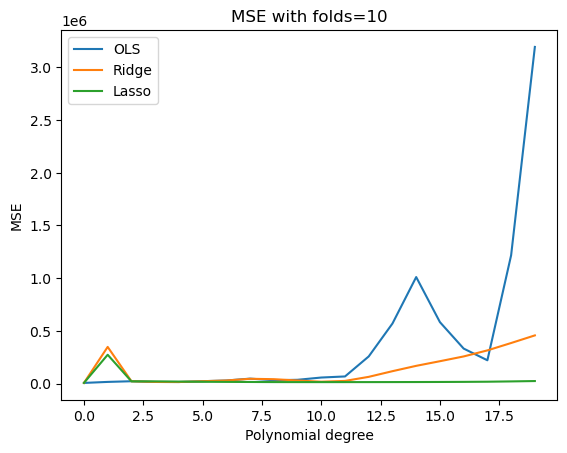

In [11]:
# Figure output directory
#RESULTS_DIR = Path("../results").resolve()
#FIGURES_DIR = RESULTS_DIR / "figures"
"""
# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""
input_folds = 10
lamb = 0.0001 #lambda input for ridge regression
maxdegree = 20
degrees = np.arange(0, maxdegree, 1)

test_OLS = OLS_model(maxdegree, input_folds)
test_Ridge = Ridge_model(maxdegree, lamb, input_folds)
test_Lasso = Lasse_model(maxdegree, input_folds)

plt.plot(degrees, test_OLS, label="OLS")
plt.plot(degrees, test_Ridge, label="Ridge")
plt.plot(degrees, test_Lasso, label="Lasso")
plt.title(f"MSE with folds={input_folds}")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()

#plt.savefig(FIGURES_DIR / "part_f_MSE_allmethods.png")